In [1]:
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import numpy as np
import math
from typing import Dict, List, Tuple
import time

In [2]:
class SkeletonDataset(Dataset):
    def __init__(self, data_path, split):
        self.X = np.load(os.path.join(data_path, f'X_{split}.npy'))
        self.y = np.load(os.path.join(data_path, f'y_{split}.npy'))
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[2], self.X.shape[1])
        self.y = np.where(self.y == 27, 0, self.y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

def get_dataloader(data_path, split, batch_size):
    dataset = SkeletonDataset(data_path, split)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Create train, validation, and test loaders
def get_all_dataloaders(data_path, batch_size):
    train_loader = get_dataloader(data_path, 'train', batch_size)
    test_loader = get_dataloader(data_path, 'test', batch_size)
    return train_loader, test_loader


In [3]:
class DistillationNPYDataset(Dataset):
    """Dataset that loads precomputed skeleton data from separate .npy files and includes DTW distances."""
    def __init__(self, folder: str, split: str, dtw_distances: np.ndarray):
        """
        Args:
            folder (str): Path to the folder containing .npy files.
            split (str): One of ['train', 'val', 'test'] to load the corresponding dataset.
            dtw_distances (np.ndarray): Precomputed DTW distance matrix.
        """
        self.X = np.load(os.path.join(folder, f'X_{split}.npy'))  # Load features
        self.y = np.load(os.path.join(folder, f'y_{split}.npy'))  # Load labels
        print(self.X.shape)
        self.dtw_distances = dtw_distances
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[2], self.X.shape[1])
        self.y = np.where(self.y == 27, 0, self.y)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx: int):
               
        sample = {
            'X': torch.tensor(self.X[idx], dtype=torch.float32),  
            'y': torch.tensor(self.y[idx], dtype=torch.long),    
            'dtw_distances': torch.tensor(self.dtw_distances[idx], dtype=torch.float32)
        }
        return sample

def get_distillation_dataloader_from_folder(folder: str, dtw_distances: np.ndarray, 
                                            batch_size: int = 16, shuffle: bool = False, 
                                            num_workers: int = 4):
    """Creates dataloaders from a given folder with precomputed NPY data and DTW distances."""
    
    train_dataset = DistillationNPYDataset(folder, 'train', dtw_distances)
    test_dataset = DistillationNPYDataset(folder, 'test', dtw_distances)
    
    def distillation_collate(batch):
        """Custom collate function for batches with DTW distances."""
        X = torch.stack([item['X'] for item in batch])
        y = torch.tensor([item['y'] for item in batch])
        dtw_distances = torch.tensor(np.stack([item['dtw_distances'] for item in batch]))
        return {'X': X, 'y': y, 'dtw_distances': dtw_distances}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, 
                              num_workers=num_workers, collate_fn=distillation_collate)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                             num_workers=num_workers, collate_fn=distillation_collate)
    
    return train_loader, test_loader
    
def compute_teacher_probabilities(dtw_distances: torch.Tensor, 
                                train_labels: torch.Tensor,
                                num_classes: int, 
                                temperature: float = 1.0) -> torch.Tensor:
    """
    Compute soft probability distributions from DTW distances
    Args:
        dtw_distances: tensor of shape (batch_size, num_training_examples)
        train_labels: tensor of shape (num_training_examples) with class labels of all training examples
        num_classes: total number of classes
        temperature: temperature parameter for softening distributions
    Returns:
        soft probabilities of shape (batch_size, num_classes)
    """
    # Convert distances to similarities (negative distances)
    similarities = -dtw_distances / temperature
    # Apply softmax to get example-wise probabilities
    example_probs = F.softmax(similarities, dim=1)  # (batch_size, num_training_examples)
    # Initialize class probabilities tensor
    batch_size = dtw_distances.shape[0]
    class_probs = torch.zeros(batch_size, num_classes, device=dtw_distances.device)
    # For each class, sum the probabilities of examples belonging to that class
    for i in range(num_classes):
        class_indices = (train_labels == i).nonzero(as_tuple=True)[0]
        if len(class_indices) > 0:
            # Sum (not mean) probabilities of all examples of this class
            class_probs[:, i] = example_probs[:, class_indices].sum(dim=1)
    # Re-normalize to ensure proper probability distribution
    # This is necessary because we're summing probabilities across examples
    class_probs = class_probs / (class_probs.sum(dim=1, keepdim=True) + 1e-8)
    return class_probs
# def compute_teacher_probabilities(dtw_distances: torch.Tensor, y:torch.Tensor,
#                                 num_classes:int, temperature: float = 1.0) -> torch.Tensor:
#     """
#     Compute soft probability distributions from DTW distances
#     Args:
#         dtw_distances: tensor of shape (batch_size, num_training_examples)
#         temperature: temperature parameter for softening distributions
#     Returns:
#         soft probabilities of shape (batch_size, num_classes)
#     """
#     # Convert distances to similarities (negative distances)
#     similarities = -dtw_distances / temperature
#     class_similarity = torch.zeros(dtw_distances.shape[0], num_classes, device=dtw_distances.device)
#     for i in range(num_classes):
#         class_indices = (y == i).nonzero(as_tuple=True)[0]
#         if len(class_indices) > 0:  # Avoid division by zero if there are no samples for the class
#             class_similarity[:, i] = similarities[:, class_indices].mean(dim=1)
#         # class_mask = (y == i).unsqueeze(1)  # Shape: (batch_size, 1)
        
#         # # For the current class, calculate the mean similarity over the relevant samples
#         # # The `class_mask` is broadcasted to the shape of the similarities tensor
#         # class_similarity[:, i] = (similarities * class_mask.float()).sum(dim=1) / class_mask.sum(dim=1).float()

    
#     # Apply softmax to get probabilities
#     probabilities = F.softmax(class_similarity, dim=1)
    
#     return probabilities


In [4]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=4, hidden_dim=256, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        
        self.input_dim = input_dim
        self.num_classes = num_classes
        
        # Transformer encoder layer
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_dim,  # Input dimension (features per frame)
            nhead=num_heads,    # Number of attention heads
            dim_feedforward=hidden_dim,  # Feedforward hidden layer size
            dropout=dropout
        )
        
        # Stacked transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers, num_layers=num_layers
        )
        
        # Classifier head
        self.fc = nn.Linear(input_dim, num_classes)  # Final layer to output class probabilities
    
    def forward(self, x):
        """
        x: (batch_size, time_steps, features)
        """
        # Transformer expects input of shape (sequence_length, batch_size, input_dim)
        x = x.permute(1, 0, 2)  # Shape: (time_steps, batch_size, features)
        
        # Apply transformer encoder
        transformer_out = self.transformer_encoder(x)
        
        # We take the output of the last time step (or average pooling across time)
        # For simplicity, let's use the last time step output (as a representation of the sequence)
        x = transformer_out[-1, :, :]  # Shape: (batch_size, features)
        
        # Classifier head to predict the class
        x = self.fc(x)
        return x

In [5]:

class EnhancedTransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=8, num_layers=6, hidden_dim=512, dropout=0.2):
        super(EnhancedTransformerClassifier, self).__init__()
        
        self.input_dim = input_dim
        self.num_classes = num_classes
        
        # Transformer encoder layer with more depth, hidden layers, and dropout
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_dim,  # Input dimension (features per frame)
            nhead=num_heads,    # Number of attention heads
            dim_feedforward=hidden_dim,  # Feedforward hidden layer size
            dropout=dropout
        )
        
        # Stacked transformer encoder with more layers (increased depth)
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers, num_layers=num_layers
        )
        
        # Use global average pooling instead of just the last time step output
        self.pooling = nn.AdaptiveAvgPool1d(1)  # Global average pooling across the time dimension
        
        # Classifier head
        self.fc = nn.Linear(input_dim, num_classes)  # Final layer to output class probabilities
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Layer Normalization for better training
        self.layer_norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        """
        x: (batch_size, time_steps, features)
        """
        # Transformer expects input of shape (sequence_length, batch_size, input_dim)
        x = x.permute(1, 0, 2)  # Shape: (time_steps, batch_size, features)
        
        # Apply transformer encoder
        transformer_out = self.transformer_encoder(x)
        
        # Global average pooling (across time_steps)
        x = transformer_out.mean(dim=0)  # Shape: (batch_size, features)
        
        # Alternatively, we could also try adaptive pooling
        # x = self.pooling(transformer_out.permute(1, 2, 0)).squeeze(-1)  # Apply global average pooling
        
        # Layer normalization for better stability
        x = self.layer_norm(x)
        
        # Dropout to regularize the output
        x = self.dropout(x)
        
        # Classifier head to predict the class
        x = self.fc(x)
        return x


In [6]:
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

def get_total_Y_distil(loader):
    all_Y = []
    for batch in loader:  # Iterate through the batches in the loader
        Y_batch = batch['y']  # Extract 'y' from each batch
        all_Y.append(Y_batch)
    
    total_Y = torch.cat(all_Y, dim=0)  # Concatenate all 'y' labels along the batch dimension
    return total_Y

def distillation_train_model(model: nn.Module, 
                           train_loader: DataLoader,
                           device: torch.device,
                           alpha: float = 0.5,
                           beta: float = 0.5, 
                           temperature: float = 3.0,
                           epochs: int = 10,
                           lr: float = 1e-4) -> Dict:
    """
    Train model using knowledge distillation
    Args:
        model: student model to be trained
        train_loader: training data loader with DTW distances
        val_loader: validation data loader
        device: device to train on
        alpha: weight for cross-entropy loss
        beta: weight for KL divergence loss
        temperature: temperature for softening distributions
        epochs: number of training epochs
        lr: learning rate
    Returns:
        training history
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.to(device)
    
    # Lists to store metrics
    train_losses = []
    train_accuracies = []
    
    train_y = get_total_Y_distil(train_loader)
    num_classes = 27 #len(set([item['y'] for item in train_loader.dataset]))  # Number of unique glosses

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]',
                         file=sys.stdout, leave=True)
        
        for batch in train_pbar:
            X_batch = batch['X'].to(device)
            y_batch = batch['y'].to(device)
            dtw_distances = batch['dtw_distances'].to(device)
            
            optimizer.zero_grad()
            
            # Student predictions
            student_logits = model(X_batch)
            student_probs = F.softmax(student_logits / temperature, dim=1)
            
            # Teacher probabilities from DTW distances
            teacher_probs = compute_teacher_probabilities(
                dtw_distances, train_y, num_classes, temperature).to(device) 
            # Compute losses
            ce_loss = criterion(student_logits, y_batch)
            kl_loss = F.kl_div(
                F.log_softmax(student_logits / temperature, dim=1),
                teacher_probs,
                reduction='batchmean'
            ) * (temperature ** 2)
            
            # Combined loss
            loss = alpha * ce_loss + beta * kl_loss
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Compute accuracy
            _, predicted = torch.max(student_logits, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            
            epoch_loss = running_loss / (train_pbar.n + 1)
            epoch_acc = 100 * correct / total
            
            train_pbar.set_postfix({
                'loss': f'{epoch_loss:.4f}',
                'acc': f'{epoch_acc:.2f}%'
            })
        
        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"\nEpoch {epoch+1}/{epochs} Summary:")
        print(f"Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
        
    
    # Return history dictionary
    return {
        'train_loss': train_losses,
        'train_acc': train_accuracies
    }



In [20]:
# root_dir = "./data/pose_hands_landmarks_iso_files"
# annotations_file = "./data/signum_signs_anno_eng.txt"

# train_signer_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# val_signer_ids = [15, 16, 17, 18]
# test_signer_ids = [19, 20, 21, 22, 23, 24, 25]

# train_loader, val_loader, test_loader = get_dataloader(
#     root_dir=root_dir,
#     annotations_file=annotations_file,
#     train_ids=train_signer_ids,
#     val_ids=val_signer_ids,
#     test_ids=test_signer_ids,
#     batch_size=16,
# )

# # Check the shape of a batch
# for X, y in train_loader:
#     print("X shape (batch_size, window_size, num_channels):", X.shape)  # Expected: (16, 80, 225)
#     print("y (labels as numeric indices):", y)  # List of numeric indices for gloss annotations
#     break


Total shape of train test and validation data

In [21]:
# def get_total_X(loader):
#     all_X = []
#     for X_batch, _ in loader:  # We only need the X_batch here
#         all_X.append(X_batch)
#     total_X = torch.cat(all_X, dim=0)  # Concatenate along the batch dimension
#     return total_X

# # Total shapes for train, validation, and test sets
# train_X = get_total_X(train_loader)
# val_X = get_total_X(val_loader)
# test_X = get_total_X(test_loader)

# # Print the total shapes
# print("Total X shape for train set:", train_X.shape)
# print("Total X shape for validation set:", val_X.shape)
# print("Total X shape for test set:", test_X.shape)

In [7]:
# Load the pre-computed DTW distances
dtw_distances = np.load('../results_skeleton_test/distances_train_all.npy')
folder_path = '../Skeleton_numpy'
# Print the shape to verify
print(f"Loaded DTW distances shape: {dtw_distances.shape}")
print(f"Contains NaN: {np.isnan(dtw_distances).any()}")
print(f"Contains Inf: {np.isinf(dtw_distances).any()}")

# Verify non-negativity
is_non_negative = (dtw_distances >= 0).all()
print(f"All distances are non-negative: {is_non_negative}")

# Dinstance nomralization
dtw_distances = (dtw_distances - dtw_distances.min()) / (dtw_distances.max() - dtw_distances.min())
# dtw_distances = (dtw_distances - dtw_distances.mean()) / dtw_distances.std()

train_loader, test_loader = get_distillation_dataloader_from_folder(
    folder=folder_path, dtw_distances=dtw_distances, batch_size=16
)

Loaded DTW distances shape: (539, 539)
Contains NaN: False
Contains Inf: False
All distances are non-negative: True
(539, 60, 125)
(322, 60, 125)


### Train model

In [10]:
input_dim = 60  # Number of features (channels)
seq_length = 125
num_classes = 27 #len(set([item['y'] for item in train_loader.dataset]))  # Number of unique glosses
num_heads = 12 #change
print(num_classes)

# Initialize model
#model = TransformerClassifier(input_dim=input_dim, num_heads=num_heads, num_classes=num_classes)
model = EnhancedTransformerClassifier(input_dim=input_dim, num_heads = num_heads, num_classes=num_classes)
print(model)

# Select device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model with distillation
history = distillation_train_model(
    model=model,
    train_loader=train_loader,
    device=device,
    alpha=0.5,  # Weight for cross-entropy loss
    beta=0.5,   # Weight for KL divergence loss
    temperature=3.0,  # Temperature for softening distributions
    epochs=2000,
    lr=1e-4
)

# Test the model on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        X_batch = batch['X']
        y_batch = batch['y']

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1/2000 [Train]: 100%|██████████| 34/34 [00:00<00:00, 42.13it/s, loss=2.0762, acc=4.08%]

Epoch 1/2000 Summary:
Training Loss: 2.0762, Accuracy: 4.08%
Epoch 2/2000 [Train]: 100%|██████████| 34/34 [00:00<00:00, 48.02it/s, loss=1.7394, acc=2.78%]

Epoch 2/2000 Summary:
Training Loss: 1.7394, Accuracy: 2.78%
Epoch 3/2000 [Train]: 100%|██████████| 34/34 [00:00<00:00, 47.49it/s, loss=1.7956, acc=3.90%]

Epoch 3/2000 Summary:
Training Loss: 1.7956, Accuracy: 3.90%
Epoch 4/2000 [Train]: 100%|██████████| 34/34 [00:00<00:00, 46.84it/s, loss=1.7848, acc=2.78%]

Epoch 4/2000 Summary:
Training Loss: 1.7848, Accuracy: 2.78%
Epoch 5/2000 [Train]: 100%|██████████| 34/34 [00:00<00:00, 47.17it/s, loss=1.7862, acc=3.53%]

Epoch 5/2000 Summary:
Training Loss: 1.7862, Accuracy: 3.53%
Epoch 6/2000 [Train]: 100%|██████████| 34/34 [00:00<00:00, 47.47it/s, loss=1.7549, acc=6.86%]

Epoch 6/2000 Summary:
Training Loss: 1.7549, Accuracy: 6.86%
Epoch 7/2000 [Train]: 100%|██████████| 34/34 [00:00<00:00, 47.89

In [11]:
model.eval()
correct = 0
total = 0
start=time.time()
with torch.no_grad():
    for batch in test_loader:
        X_batch = batch['X']
        y_batch = batch['y']

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
end = time.time()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
print("Time per sample:", (end-start)*1000/total)


Test Accuracy: 64.91%
Time per sample: 0.831443330515986


In [12]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        X_batch = batch['X']
        y_batch = batch['y']

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_labels.extend(y_batch.cpu().numpy())  # Collect true labels

# Calculate precision, recall, F1 score (macro averaged), and accuracy
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
accuracy = accuracy_score(all_labels, all_preds)

print(f"Test Accuracy: {accuracy * 100}")
print(f"Test Precision (Macro): {precision}")
print(f"Test Recall (Macro): {recall}")
print(f"Test F1 Score (Macro): {f1}")


Test Accuracy: 64.90683229813664
Test Precision (Macro): 0.6718821948096114
Test Recall (Macro): 0.6498316498316499
Test F1 Score (Macro): 0.6395877784159046


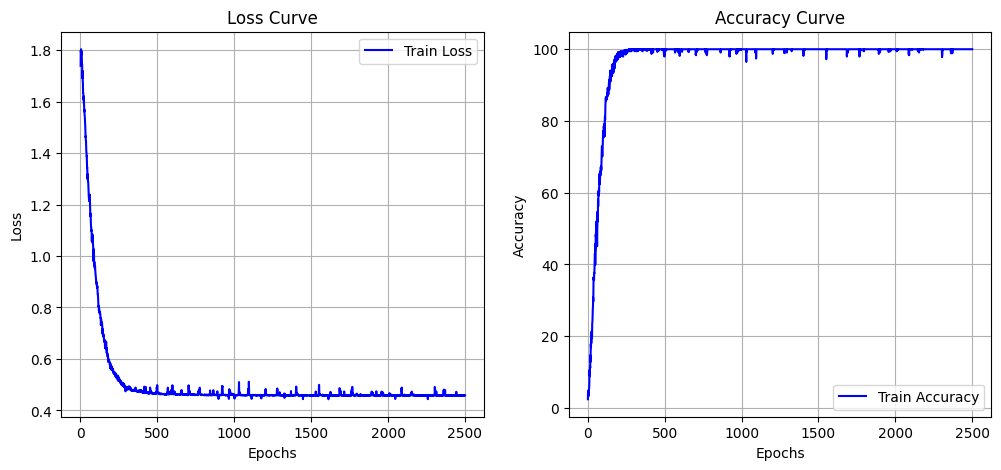

In [13]:
# Extract values from history
train_loss = history["train_loss"]
#val_loss = history["val_loss"]
train_acc = history["train_acc"]
#val_acc = history["val_acc"]
epochs = range(1, len(train_loss) + 1)

# Plot Loss Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label="Train Loss")
#plt.plot(epochs, val_loss, 'r-', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-',label="Train Accuracy")
#plt.plot(epochs, val_acc, 'r-', label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid()

plt.show()


In [14]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        X_batch = batch['X']
        y_batch = batch['y']

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 90.69%


In [26]:
# Generate classification report and confusion matrix
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        X_batch = batch['X']
        y_batch = batch['y']
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(y_batch.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Classification Report
print("Classification Report:")
report = classification_report(true_labels, predicted_labels, target_names=train_loader.dataset.idx_to_gloss.values(), zero_division=0)
print(report)

# Confusion Matrix (optional for large datasets)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualizing diagonal counts for correct predictions
diag_counts = np.diag(conf_matrix)
plt.figure(figsize=(10, 5))
plt.bar(range(len(diag_counts)), diag_counts, color='blue')
plt.xlabel("Class Index")
plt.ylabel("Correct Predictions")
plt.title("Correct Predictions per Class (Diagonal of Confusion Matrix)")
plt.show()

# Heatmap for confusion matrix (cropped or full)
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix[:50, :50], annot=False, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix (First 50 Classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Classification Report:


AttributeError: 'DistillationNPYDataset' object has no attribute 'idx_to_gloss'